# 準備

## DB作成
### LangChainのGit公式ドキュメントをDBとする

In [1]:
from langchain_community.document_loaders import GitLoader
import os

os.environ["GIT_PYTHON_REFRESH"] = "quiet"

def file_filter(file_path: str) -> bool:
    return file_path.endswith(".mdx")

loader = GitLoader(
    clone_url="https://github.com/langchain-ai/langchain",
    repo_path="./langchain",
    branch="master",
    file_filter=file_filter,
)

documents = loader.load()
print(len(documents))

384


In [2]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
db = Chroma.from_documents(documents, embeddings)

## LangSmithとの連携

In [3]:
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]="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"
os.environ["LANGCHAIN_PROJECT"]="AI-Agent"

# Basic RAG

In [4]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_template(
    '''\
    以下の文脈だけを踏まえて質問に回答してください。

    文脈： """
    {context}
    """

    質問： """
    {question}
    """
    '''
)

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
retriever = db.as_retriever()

chain = {
    "question": RunnablePassthrough(),
    "context": retriever,
} | prompt | model | StrOutputParser()

chain.invoke("LangChainの概要を教えて")

'LangChainは、大規模言語モデル（LLM）を活用したアプリケーションを開発するためのフレームワークです。このフレームワークは、LLMアプリケーションのライフサイクルの各段階を簡素化します。具体的には、以下のような機能があります：\n\n1. **開発**: LangChainのオープンソースコンポーネントやサードパーティの統合を使用してアプリケーションを構築できます。LangGraphを利用することで、状態を持つエージェントを構築し、ストリーミングや人間の介入をサポートします。\n\n2. **生産化**: LangSmithを使用してアプリケーションを検査、監視、評価し、継続的に最適化して自信を持ってデプロイできます。\n\n3. **デプロイ**: LangGraphアプリケーションを生産準備が整ったAPIやアシスタントに変換できます。\n\nLangChainは、LLMや関連技術（埋め込みモデルやベクターストアなど）に対する標準インターフェースを実装しており、数百のプロバイダーと統合されています。また、複数のオープンソースライブラリで構成されており、特に`langchain-core`、統合パッケージ、`langchain`、`langchain-community`、`langgraph`などが含まれています。\n\nこのフレームワークは、開発者がアプリケーションを簡単に構築できるように設計されており、さまざまなコンポーネントを組み合わせて使用することができます。'

# 検索クエリの工夫

## HyDE (Hypothetical Document Embeddings)
- ユーザーの質問に対して、LLMに仮説的な回答を推論させ、その出力を類似度検索に用いる

In [5]:
hypo_prompt = ChatPromptTemplate.from_template(
    """\
    次の質問に回答する一文を書いてください。

    質問： {question}
    """
)

hypo_chain = hypo_prompt | model | StrOutputParser()

hyde_rag_chain = {
    "question": RunnablePassthrough(),
    "context": hypo_chain | retriever,
} | RunnablePassthrough.assign(answer=prompt | model | StrOutputParser())

output = hyde_rag_chain.invoke("LangChainの概要を教えて")

In [6]:
import pprint
pprint.pprint(output["answer"])

('LangChainは、大規模言語モデル（LLM）を活用したアプリケーションを開発するためのフレームワークです。LangChainは、アプリケーションのライフサイクルの各段階を簡素化します。具体的には、以下のような機能を提供しています：\n'
 '\n'
 '1. **開発**: '
 'LangChainのオープンソースコンポーネントやサードパーティの統合を使用してアプリケーションを構築できます。また、LangGraphを利用して、状態を持つエージェントを構築することができます。\n'
 '\n'
 '2. **生産化**: LangSmithを使用してアプリケーションを検査、監視、評価し、継続的に最適化して自信を持ってデプロイできます。\n'
 '\n'
 '3. **デプロイ**: LangGraphアプリケーションを本番環境向けのAPIやアシスタントに変換できます。\n'
 '\n'
 'LangChainは、さまざまなプロバイダーと統合し、標準インターフェースを実装しているため、異なるコンポーネントを簡単に切り替えたり、組み合わせたりすることが可能です。また、LangGraphを使用することで、複雑なアプリケーションのオーケストレーションが可能になり、持続性やストリーミング、ヒューマンインザループなどの機能をサポートします。LangSmithは、アプリケーションのトレースや評価を行うためのプラットフォームです。\n'
 '\n'
 '全体として、LangChainは開発者がLLMアプリケーションを効率的に構築、評価、デプロイできるように設計されています。')


## 複数の検索クエリの生成
- LLMに複数の検索クエリを生成させ類似検索に用いることで、適切なドキュメントが検索結果に含まれやすくする

In [7]:
from pydantic import BaseModel, Field

class QueryGenerationOutput(BaseModel):
    queries: list[str] = Field(..., description="検索クエリのリスト")

query_generation_prompt = ChatPromptTemplate.from_template(
    """\
    質問に対してベクターデータベースから関連文書を検索するために、3つの異なる検索クエリを生成してください。
    距離ベースの類似性検索の限界を克服するために、ユーザーの質問に対して複数の視点を提供することが目標です。

    質問： {question}
    """
)

query_generation_chain = (
    query_generation_prompt
    | model.with_structured_output(QueryGenerationOutput)
    | (lambda x: x.queries)
)

- マルチクエリの例   
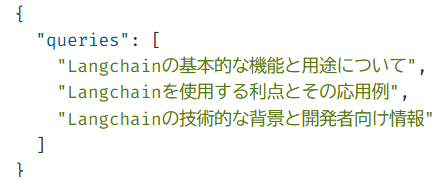

In [8]:
"""
retriever.map() : list[str]を受け取って、list[list[Document]]を返すように変換。
                  元のRunnableに対して引数と戻り値をlist化するメソッド。
"""

multi_query_rag_chain = {
    "question": RunnablePassthrough(),
    "context": query_generation_chain | retriever.map(), 
} | prompt | model | StrOutputParser()

output = multi_query_rag_chain.invoke("Langchainの概要を教えて")

In [10]:
print(output)

LangChainは、大規模言語モデル（LLM）を活用したアプリケーションを開発するためのフレームワークです。LangChainは、開発、運用、デプロイの各段階を簡素化し、開発者がアプリケーションを構築しやすくすることを目指しています。

### 主な特徴
1. **標準化されたコンポーネントインターフェース**: LangChainは、さまざまなAIアプリケーションにおいて中心的な役割を果たすコンポーネントのための共通インターフェースを提供します。これにより、異なるプロバイダー間での切り替えが容易になります。

2. **オーケストレーション**: 複数のコンポーネントやモデルを組み合わせて複雑なアプリケーションを構築するための効率的な接続が求められています。LangChainは、これを実現するためのオーケストレーション機能を提供します。

3. **可観測性と評価**: アプリケーションが複雑になるにつれて、内部で何が起こっているのかを理解することが難しくなります。LangChainは、アプリケーションの監視や評価を支援するツールを提供し、開発者が自信を持って迅速に質問に答えられるようにします。

### エコシステム
LangChainは、オープンソースのコンポーネントやサードパーティの統合を利用してアプリケーションを構築するためのフレームワークであり、LangGraphやLangSmithといった関連ツールも含まれています。LangGraphは、LangChainコンポーネントを組み合わせて状態を持つアプリケーションを構築するためのオーケストレーションフレームワークであり、LangSmithはアプリケーションのトレース、モニタリング、評価を行うためのプラットフォームです。

このように、LangChainは開発者がAIアプリケーションを効率的に構築、運用、デプロイできるように設計されています。


## Step-Back Prompting
- 元の質問を抽象度の高い質問に言い換える

In [11]:
step_back_prompt = ChatPromptTemplate.from_template(
    """\
    次の質問を抽象度の高い質問に言い換えてください。

    質問： {question}
    """
)

step_back_chain = step_back_prompt | model | StrOutputParser()

step_back_rag_chain = {
    "question": RunnablePassthrough(),
    "context": step_back_chain | retriever,
} | RunnablePassthrough.assign(answer=prompt | model | StrOutputParser())

output = step_back_rag_chain.invoke("LangChainの概要を教えて")

- 変換の結果

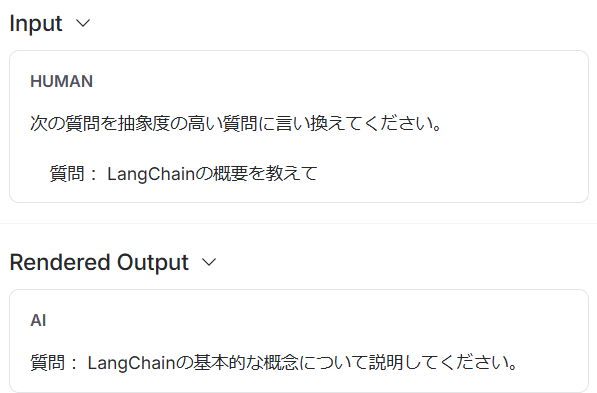

In [13]:
print(output["answer"])

LangChainは、大規模言語モデル（LLM）を活用したアプリケーションを開発するためのフレームワークです。LangChainは、アプリケーションのライフサイクルの各段階を簡素化します。具体的には、以下のような機能を提供しています：

- **開発**: LangChainのオープンソースコンポーネントやサードパーティの統合を使用してアプリケーションを構築できます。また、LangGraphを利用して、状態を持つエージェントを構築することができます。
- **生産化**: LangSmithを使用してアプリケーションを検査、監視、評価し、継続的に最適化して自信を持ってデプロイできます。
- **デプロイ**: LangGraphアプリケーションを本番環境向けのAPIやアシスタントに変換できます。

LangChainは、さまざまなプロバイダーと統合し、標準インターフェースを実装しているため、開発者は異なるコンポーネントを簡単に切り替えたり、組み合わせたりすることができます。また、LangGraphを使用することで、複雑なアプリケーションのオーケストレーションが可能になります。さらに、LangSmithを利用することで、アプリケーションの可視化や評価を行い、信頼性の高いアプリケーションを構築することができます。


# 検索後の工夫

## RAG-Fusion
- 複数のクエリの検索結果を何らかの順番で並べ、その結果から最終的な回答をLLMが作成
- 検索結果の順位を融合して並べるアルゴリズムとして、RRF(Recirocal Rank Fusion)がある。
  - RRFは各検索クエリの「1 / (順位+k」(kはパラメータで一般的に60)の合計スコアで検索結果のドキュメントを並び替える
  - 各検索クエリで全て1位に含まれたドキュメントが最も重要と判断され、出力優先度が高くなる

In [15]:
from langchain_core.documents import Document

def reciprocal_rank_fusion(
    retriever_outputs: list[list[Document]],
    k: int = 60,
) -> list[str]:
    # 各ドキュメントのコンテンツ（文字列）とそのスコアの対応を保持する辞書を準備
    content_score_mapping = {}

    # 検索クエリごとにループ
    for docs in retriever_outputs:
        # 検索結果のドキュメントごとにループ
        for rank, doc in enumerate(docs):
            content = doc.page_content

            # 初めて登場したコンテンツの場合はスコアを0で初期化
            if content not in content_score_mapping:
                content_score_mapping[content] = 0

            # (1 / (順位 + k))のスコアを加算
            content_score_mapping[content] += 1 / (rank + k)

    # スコアの大きい順にソート
    ranked = sorted(content_score_mapping.items(), key=lambda x: x[1], reverse=True)
    return [content for content, _ in ranked]

In [16]:
rag_fusion_chain = {
    "question": RunnablePassthrough(),
    "context": query_generation_chain | retriever.map() | reciprocal_rank_fusion,
} | prompt | model | StrOutputParser()

outout = rag_fusion_chain.invoke("LangChainの概要を教えて")

In [17]:
print(outout)

LangChainは、大規模言語モデル（LLM）を活用したアプリケーションを開発するためのフレームワークです。このフレームワークは、LLMアプリケーションのライフサイクルの各段階を簡素化します。具体的には、以下のような機能を提供しています。

1. **開発**: LangChainのオープンソースコンポーネントやサードパーティの統合を使用してアプリケーションを構築できます。また、LangGraphを利用して、状態を持つエージェントを構築し、ストリーミングや人間の介入をサポートします。

2. **生産化**: LangSmithを使用してアプリケーションを検査、監視、評価し、継続的に最適化して自信を持ってデプロイできます。

3. **デプロイ**: LangGraphアプリケーションを生産準備が整ったAPIやアシスタントに変換できます。

LangChainは、チャットモデルや埋め込みモデル、ベクトルストアなど、さまざまなAI関連技術の標準インターフェースを実装しており、数百のプロバイダーと統合されています。これにより、開発者は異なるプロバイダー間で簡単に切り替えたり、コンポーネントを組み合わせたりすることができます。

また、LangChainは、アプリケーションの複雑さが増す中で、複数のコンポーネントやモデルを効率的に接続するためのオーケストレーション機能も提供しています。これにより、複雑な制御フローや人間の介入を必要とするアプリケーションの構築が可能になります。

全体として、LangChainは、AIアプリケーションの開発を容易にし、開発者が迅速にプロトタイプを作成し、信頼性の高いアプリケーションを構築できるようにすることを目指しています。


# 複数のRetrieverを使う工夫

## LLMによるルーティング
- ユーザーの質問に応じて検索対象のRetrieverをLLMが使い分ける

In [19]:
from langchain_community.retrievers import TavilySearchAPIRetriever
os.environ["TAVILY_API_KEY"] = "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"

# Retriever1 : LangChainの公式ドキュメント
langchain_document_retriever = retriever.with_config(
    {"run_name": "langchain_document_retriever"}
)

# Retriever2 : Web検索
web_retriever = TavilySearchAPIRetriever(k=3).with_config(
    {"run_name": "web_retriever"}
)

In [24]:
### ユーザー入力を元にLLMがRetrieverを選択するChain
from enum import Enum

class Route(str, Enum):
    langchain_document = "langchain_document"
    web = "web"

class RouteOutput(BaseModel):
    route: Route

route_prompt = ChatPromptTemplate.from_template(
    """\
    質問に回答するために適切なRetrieverを選択してください。

    質問： {question}
    """
)

route_chain = (
    route_prompt
    | model.with_structured_output(RouteOutput)
    | (lambda x: x.route)
)

In [27]:
### ルーティングの結果を踏まえて検索するrouted_retriever関数とChainを実装
from typing import Any

def routed_retriever(inp: dict[str, Any]) -> list[Document]:
    question = inp["question"]
    route = inp["route"]

    if route == Route.langchain_document:
        return langchain_document_retriever.invoke(question)
    elif route == Route.web:
        return web_retriever.invoke(question)

    raise ValueError(f"Unknown retriever: {retriever}")

route_rag_chain = (
    {
        "question": RunnablePassthrough(),
        "route": route_chain,
    }
    | RunnablePassthrough.assign(context=routed_retriever)
    | prompt | model | StrOutputParser()
)

output = route_rag_chain.invoke("LangChainの概要を教えて")

In [28]:
print(output)

LangChainは、大規模言語モデル（LLMs）を活用したアプリケーションを開発するためのフレームワークです。このフレームワークは、LLMアプリケーションのライフサイクルの各段階を簡素化します。具体的には、以下のような機能があります：

1. **開発**: LangChainのオープンソースコンポーネントやサードパーティの統合を使用してアプリケーションを構築できます。また、LangGraphを利用して、状態を持つエージェントを構築し、ストリーミングや人間の介入をサポートします。

2. **生産化**: LangSmithを使用してアプリケーションを検査、監視、評価し、継続的に最適化して自信を持ってデプロイできます。

3. **デプロイ**: LangGraphアプリケーションを生産準備が整ったAPIやアシスタントに変換できます。

LangChainは、LLMや関連技術（埋め込みモデルやベクターストアなど）に対する標準インターフェースを実装しており、数百のプロバイダーと統合されています。また、複数のオープンソースライブラリで構成されており、特に`langchain-core`、統合パッケージ、`langchain`、`langchain-community`、`langgraph`などが含まれています。

このフレームワークは、開発者がアプリケーションを簡単に構築できるように設計されており、さまざまなコンポーネントを組み合わせて使用することができます。


In [29]:
route_rag_chain.invoke("今日の東京の天気は？")

'今日、2024年11月19日（火）の東京の天気は「晴時々曇」で、最高気温は13℃、最低気温は8℃です。降水確率は0％で、風は北の風から北東の風に変わります。'

## ハイブリッド検索
- 複数のRetrieverの検索結果を組み合わせて結果を出力
- TF-IDFの拡張機能であるBM25とEmbeddingモデルの２つを組み合わせる
   - 固有名詞や専門用語を扱う場合はBM25の方が有効な可能性がある

In [32]:
from langchain_community.retrievers import BM25Retriever

# EmbeddingモデルのRetriever
chroma_retriever = retriever.with_config(
    {"run_name": "chroma_retriever"}
)

# BM25を使った検索用のRetriever
bm25_retriever = BM25Retriever.from_documents(documents).with_config(
    {"run_name": "bm25_retriever"}
)

In [33]:
from langchain_core.runnables import RunnableParallel

hybrid_retriever = (
    RunnableParallel({
        "chroma_documents": chroma_retriever,
        "bm25_documents": bm25_retriever,
    })
    | (lambda x: [x["chroma_documents"], x["bm25_documents"]])
    | reciprocal_rank_fusion # 検索結果の融合にRRFを使う
)

In [34]:
hybrid_rag_chain = (
    {
        "question": RunnablePassthrough(),
        "context": hybrid_retriever,
    }
    | prompt | model | StrOutputParser()
)

output = hybrid_rag_chain.invoke("Langchainの概要を教えて")

In [35]:
print(output)

LangChainは、大規模言語モデル（LLM）を活用したアプリケーションを開発するためのフレームワークです。このフレームワークは、LLMアプリケーションのライフサイクルの各段階を簡素化します。具体的には、以下のような機能があります：

1. **開発**: LangChainのオープンソースコンポーネントやサードパーティの統合を使用してアプリケーションを構築できます。LangGraphを利用して、状態を持つエージェントを作成し、ストリーミングや人間の介入をサポートします。

2. **生産化**: LangSmithを使用してアプリケーションを検査、監視、評価し、継続的に最適化して自信を持ってデプロイできます。

3. **デプロイ**: LangGraphアプリケーションを生産準備が整ったAPIやアシスタントに変換できます。

LangChainは、チャットモデルや埋め込みモデル、ベクトルストアなどの関連技術に対する標準インターフェースを実装しており、数百のプロバイダーと統合されています。また、複数のオープンソースライブラリで構成されており、特に`langchain-core`、統合パッケージ、`langchain-community`、`langgraph`などが含まれています。

さらに、LangChainは、開発者がアプリケーションを構築する際に直面するさまざまな課題に対処するための標準化されたコンポーネントインターフェース、オーケストレーション機能、観測性と評価のサポートを提供しています。


### EnsembleRetrieverライブラリを使って実装
- 重みづけを設定し、RRFで融合する

In [37]:
from langchain.retrievers import EnsembleRetriever

# initialize the ensemble retriever
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, chroma_retriever], weights=[0.5, 0.5], c=60
)

In [38]:
hybrid_rag_chain = (
    {
        "question": RunnablePassthrough(),
        "context": ensemble_retriever,
    }
    | prompt | model | StrOutputParser()
)

output = hybrid_rag_chain.invoke("Langchainの概要を教えて")

In [39]:
print(output)

LangChainは、大規模言語モデル（LLM）を活用したアプリケーションを開発するためのフレームワークです。このフレームワークは、LLMアプリケーションのライフサイクルの各段階を簡素化します。具体的には、以下のような機能があります：

1. **開発**: LangChainのオープンソースコンポーネントやサードパーティの統合を使用してアプリケーションを構築できます。LangGraphを利用することで、状態を持つエージェントを構築し、ストリーミングや人間の介入をサポートします。

2. **生産化**: LangSmithを使用してアプリケーションを検査、監視、評価し、継続的に最適化して自信を持ってデプロイできます。

3. **デプロイ**: LangGraphアプリケーションを生産準備が整ったAPIやアシスタントに変換できます。

LangChainは、LLMや関連技術（埋め込みモデルやベクトルストアなど）に対する標準インターフェースを実装し、数百のプロバイダーと統合しています。また、複数のオープンソースライブラリで構成されており、各種機能を持つコンポーネントを組み合わせて複雑なアプリケーションを構築することが可能です。
